In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax

import icomo


sys.path.append("../")
from tapm import model_STI
from tapm import sti_infection_results_LambdaP
from tapm import utils

ModuleNotFoundError: No module named 'tapm'

## Model

In [2]:
args, y0 = utils.read_params(filename="model_params.txt")
integrator = model_STI.setup_model(args, y0)

INFO:tapm.STI.model_STI:Model setup complete and ready for simulation


## Sweep

## Hs, Ps are continuous from 0 to 0.2 and 0 to 1 respectively. Lambda_P with 8 discrete steps

In [3]:
# Define the ranges for H (HIV prevalence) and P (proportion of HIV positive individuals)
Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0

# Define different values for lambda_P (proportional infection rate due to HIV prevalence)
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
    0.1 / 360,
]

In [4]:
results = sti_infection_results_LambdaP.compute_sti_infections(
    Hs,
    Ps,
    lambda_P_values,
    y0,
    args,
    integrator,
    model_STI,
    filename="results_from_modified_sti_sweep",
)

INFO:tapm.STI.sti_infection_results_LambdaP:Processing lambda_P: 0.016666666666666666
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:tapm.STI.model_STI:Using exponential function to calculate m
INFO:tapm.STI.model_STI:Parameters: min_exp = 0.0, max_exp = 1.0, tau_exp = 0.2


## Not important

<>:62: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\2109308737.py:62: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


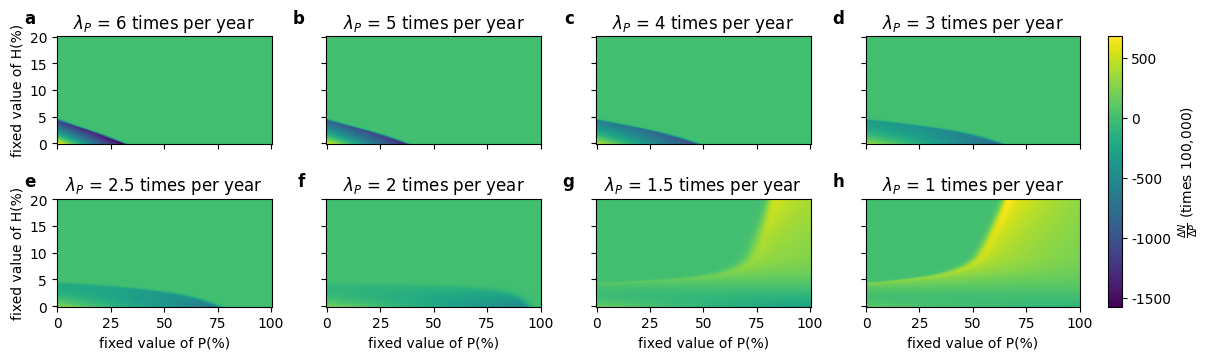

In [56]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Compute the derivative of N with respect to P
def compute_derivative(res_infections, Ps):
    delN_delP = np.gradient(res_infections, Ps, axis=1)
    return delN_delP


# Determine the global vmin and vmax for the derivative
all_derivatives = np.concatenate(
    [
        compute_derivative(results[lambda_P]["res_infections"], Ps).flatten()
        for lambda_P in lambda_P_values
    ]
)

global_vmin = np.min(all_derivatives)
global_vmax = np.max(all_derivatives)

num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    delN_delP = compute_derivative(res_infections, Ps)
    cax = ax.imshow(delN_delP, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel(r"$\frac{\Delta N}{\Delta P}$ (times 100,000)")
# fig.suptitle(
#     "Derivative of endemic new infections with respect to P"
# )

plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\1840730632.py:56: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\1840730632.py:107: UserWarning: Adding colorbar to a different Figure <Figure size 1200x350 with 9 Axes> than <Figure size 1200x350 with 9 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(


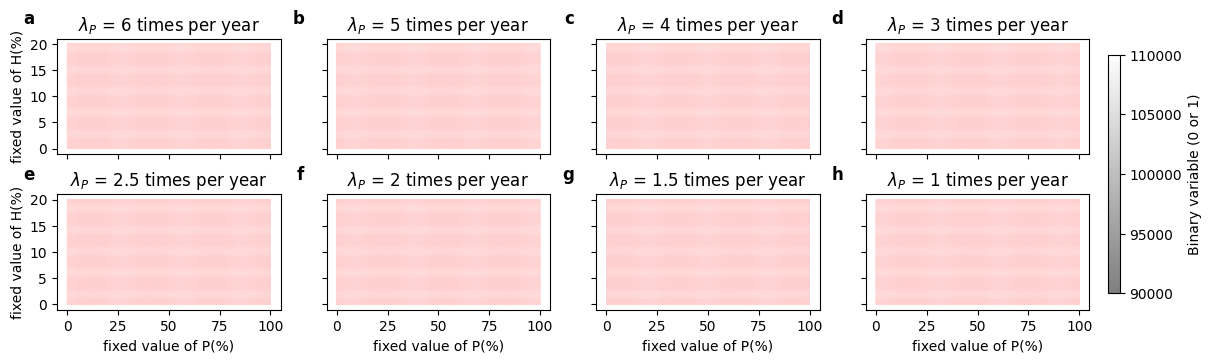

In [53]:
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]

    # Compute the partial derivatives
    dN_dP = np.gradient(res_infections, axis=1)  # Partial derivative with respect to P
    dN_dH = np.gradient(res_infections, axis=0)  # Partial derivative with respect to H

    # Create a binary heatmap
    binary_heatmap = (res_infections > 0).astype(int)

    # Create a meshgrid for P and H
    P, H = np.meshgrid(
        np.arange(res_infections.shape[1]), np.arange(res_infections.shape[0])
    )

    # Plot the binary heatmap
    cax = ax.imshow(binary_heatmap, origin="lower", cmap="gray", alpha=0.5)

    # Plot the vector field
    quiver = ax.quiver(P, H, dN_dP, dN_dH, scale=1, scale_units="xy", color="red")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("Binary variable (0 or 1)")
# fig.suptitle(
#     "Vector field of new infections with respect to P and H over binary heatmap"
# )

plt.show()

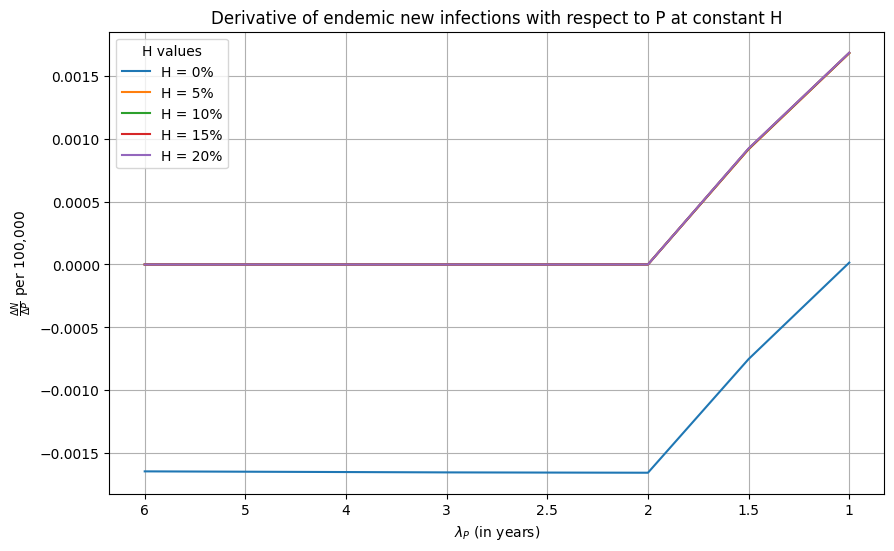

In [35]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()

lambda_P_labels = [
    "6",
    "5",
    "4",
    "3",
    "2.5",
    "2",
    "1.5",
    "1",
]

lambda_P_values = list(results.keys())


# Define a function to compute the derivative of N with respect to P
def compute_derivative(res_infections, Ps):
    delN_delP = np.gradient(res_infections, Ps, axis=1)
    return delN_delP


# Compute the derivative for each lambda_P
derivatives = {
    lambda_P: compute_derivative(results[lambda_P]["res_infections"], Ps)
    for lambda_P in lambda_P_values
}

# Define the H values to plot
H_indices = [0, 25, 50, 75, 100]  # Indices corresponding to different H values
H_labels = [int(Hs[i] * 100) for i in H_indices]

# Plotting
plt.figure(figsize=(10, 6))

for H_idx, H_label in zip(H_indices, H_labels):
    delN_delP_values = [derivatives[lambda_P][H_idx, :] for lambda_P in lambda_P_values]
    mean_delN_delP = [np.mean(delN_delP) for delN_delP in delN_delP_values]
    plt.plot(lambda_P_labels, mean_delN_delP, label=f"H = {H_label}%")

plt.xlabel(r"$\lambda_P$ (in years)")
plt.ylabel(r"$\frac{\Delta N}{\Delta P}$ per 100,000")
plt.title(r"Derivative of endemic new infections with respect to P at constant H")
plt.legend(title="H values")
plt.grid(True)
plt.show()

# Figures

## Endemic new infections (i.e., transitions from S to Ia + transitions from S to Is)

3.365187894304176e-53 0.0019747944310991544


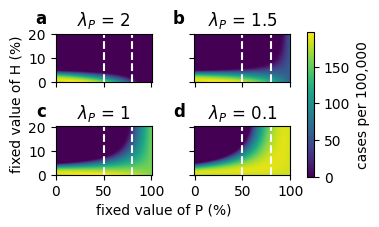

In [11]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()


# Define lambda_P values and labels


lambda_P_labels = [
    "6",
    "5",
    "4",
    "3",
    "2",
    "1.5",
    "1",
    "0.1",
]


# Select specific lambda_P values to plot


selected_lambda_P_indices = [4, 5, 6, 7]


selected_lambda_P_values = [lambda_P_values[i] for i in selected_lambda_P_indices]


selected_lambda_P_labels = [lambda_P_labels[i] for i in selected_lambda_P_indices]


# Define a formatter function that multiplies the value by 100,000


def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax


all_infections = np.concatenate(
    [
        results[lambda_P]["res_infections"].flatten()
        for lambda_P in selected_lambda_P_values
    ]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)

print(global_vmin, global_vmax)


num_lambda_P = len(selected_lambda_P_values)


ncols = 2


nrows = (num_lambda_P + ncols - 1) // ncols  # Calculate the number of rows needed


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1.1, 1.1],
    "height_ratios": [1.1, 1.1],
}


fig, axes = plt.subplots(
    nrows, ncols, figsize=(3.5, 2), constrained_layout=True, gridspec_kw=gridspec
)


# Flatten axes array for easy iteration
axes = axes.flatten()


for idx, lambda_P in enumerate(selected_lambda_P_values):

    ax = axes[idx]

    res_infections = results[lambda_P]["res_infections"]

    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)

    ax.set_title(f"$\\lambda_P$ = {selected_lambda_P_labels[idx]}")

    # Set xlabels only on the bottom most subplots

    if idx // ncols == nrows - 1:

        # ax.set_xlabel("P (%)")

        ax.set_xticks([0, 100, 200])

        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ]
        )

    else:

        ax.set_xticks([0, 100, 200])

        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots

    if idx % ncols == 0:

        # ax.set_ylabel("H (%)")

        ax.set_yticks([0, 50, 100])

        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:

        ax.set_yticks([0, 50, 100])

        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.5,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

    ax.set_ylim(-0.05, 101)

    # Add a dashed line at P = 50 and 90

    ax.vlines(np.where(Ps == 0.5)[0][0], 0, 100, color="white", linestyle="--")

    ax.vlines(np.where(Ps == 0.8)[0][0], 0, 100, color="white", linestyle="--")

    # Add a dashed line at H = 0, 10, and 20

    # ax.hlines(np.where(Hs == 0.0)[0][0], 0, 200, color="white", linestyle="--")

    # ax.hlines(np.where(Hs == 0.1)[0][0], 0, 200, color="white", linestyle="--")

    # ax.hlines(np.where(Hs == 0.2)[0][0], 0, 200, color="white", linestyle="--")


# Hide any unused subplots


for idx in range(num_lambda_P, len(axes)):

    fig.delaxes(axes[idx])


# Create a single color bar for the whole figure


cbar = fig.colorbar(
    cax,
    ax=axes[:num_lambda_P].tolist(),
    shrink=0.9,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


# Add a single x-label and y-label for the whole plot


fig.text(0.4, -0.03, "fixed value of P (%)", ha="center", va="center")


fig.text(
    -0.02, 0.5, "fixed value of H (%)", ha="center", va="center", rotation="vertical"
)


plt.show()


# Save the results to a file


fig.savefig("../figures/endemic_real_infections.pdf", format="pdf", bbox_inches="tight")

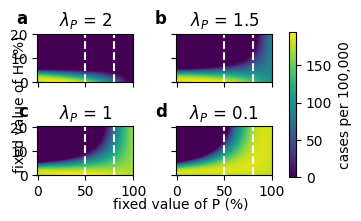

In [13]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()

# Define lambda_P values and labels
lambda_P_labels = [
    "6",
    "5",
    "4",
    "3",
    "2",
    "1.5",
    "1",
    "0.1",
]

# Select specific lambda_P values to plot
selected_lambda_P_indices = [4, 5, 6, 7]
selected_lambda_P_values = [lambda_P_values[i] for i in selected_lambda_P_indices]
selected_lambda_P_labels = [lambda_P_labels[i] for i in selected_lambda_P_indices]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [
        results[lambda_P]["res_infections"].flatten()
        for lambda_P in selected_lambda_P_values
    ]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

num_lambda_P = len(selected_lambda_P_values)
ncols = 2
nrows = (num_lambda_P + ncols - 1) // ncols  # Calculate the number of rows needed

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1.1, 1.1],
    "height_ratios": [1.1, 1.1],
}
fig, axes = plt.subplots(
    nrows, ncols, figsize=(3.5, 2), constrained_layout=True, gridspec_kw=gridspec
)

# Flatten axes array for easy iteration
axes = axes.flatten()

for idx, lambda_P in enumerate(selected_lambda_P_values):
    ax = axes[idx]
    res_infections = results[lambda_P]["res_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {selected_lambda_P_labels[idx]}")

    # Set xlabels only on the bottom most subplots
    if idx // ncols == nrows - 1:
        # ax.set_xlabel("P (%)")
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[100] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if idx % ncols == 0:
        # ax.set_ylabel("H (%)")
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[50] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.5,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )
    ax.set_ylim(-0.05, 101)

    # Add a dashed line at P = 50 and 90
    ax.vlines(np.where(Ps == 0.5)[0][0], 0, 100, color="white", linestyle="--")
    ax.vlines(np.where(Ps == 0.8)[0][0], 0, 100, color="white", linestyle="--")

    # Add a dashed line at H = 0, 10, and 20
    # ax.hlines(np.where(Hs == 0.0)[0][0], 0, 200, color="white", linestyle="--")
    # ax.hlines(np.where(Hs == 0.1)[0][0], 0, 200, color="white", linestyle="--")
    # ax.hlines(np.where(Hs == 0.2)[0][0], 0, 200, color="white", linestyle="--")

# Hide any unused subplots
for idx in range(num_lambda_P, len(axes)):
    fig.delaxes(axes[idx])

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes[:num_lambda_P].tolist(),
    shrink=0.9,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

# Add a single x-label and y-label for the whole plot
fig.text(0.5, 0.0, "fixed value of P (%)", ha="center", va="center")
fig.text(
    0.04, 0.5, "fixed value of H (%)", ha="center", va="center", rotation="vertical"
)

plt.show()

# Save the results to a file
fig.savefig("../figures/endemic_real_infections.pdf", format="pdf", bbox_inches="tight")

<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\2200025790.py:64: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


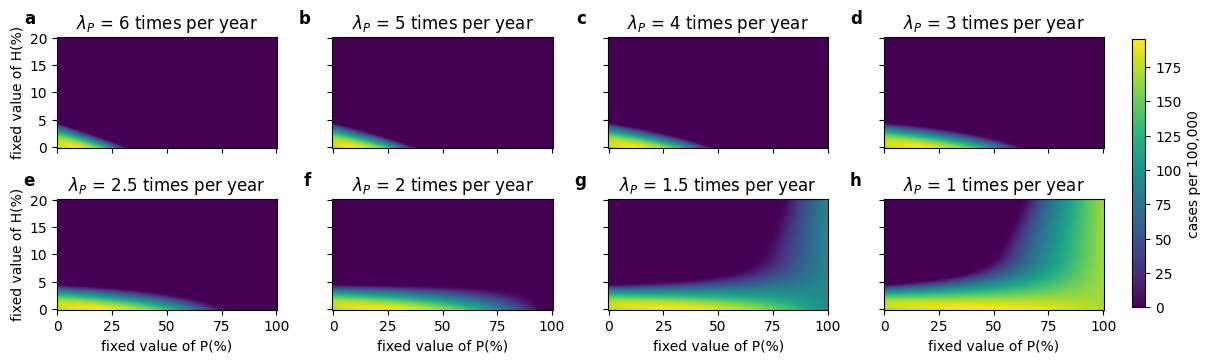

In [58]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()

# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_infections"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle(
#     "Endemic new infections (i.e., transitions from S to Ia + transitions from S to Is)"
# )


plt.show()

# Save the results to a file
# fig.savefig("../figures/endemic_new_infections.pdf", format="pdf")

## Endemic new asymptomatic infections (i.e., transitions from S to Ia)

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\673112202.py:58: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


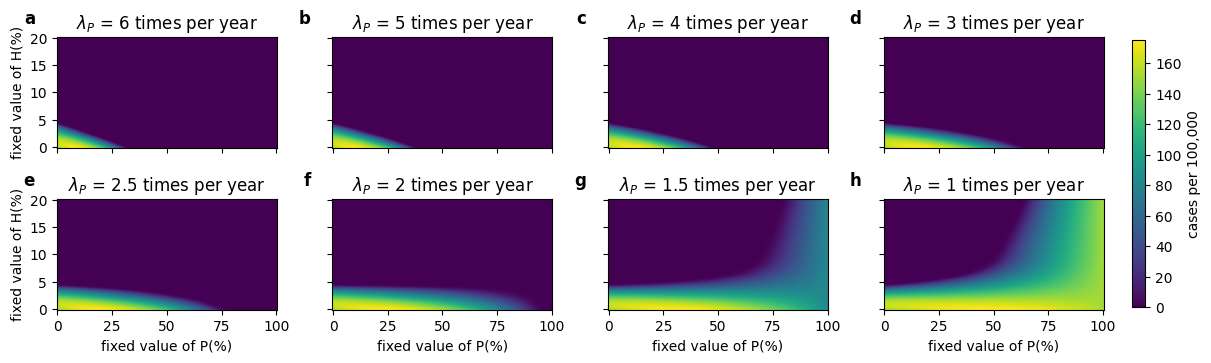

In [25]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [
        results[lambda_P]["res_asymp_infections"].flatten()
        for lambda_P in lambda_P_values
    ]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_asymp_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle(
#     "Endemic new asymptomatic infections (i.e., transitions from S to Ia)"
# )


plt.show()

## Endemic new symptomatic infections (i.e., transitions from S to Is)

<>:95: SyntaxWarning: invalid escape sequence '\l'
<>:95: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_16104\3781301421.py:95: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


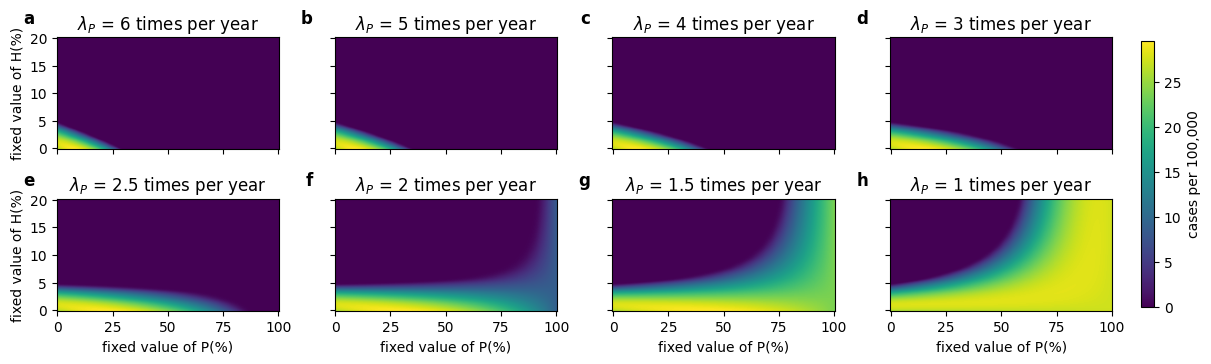

In [12]:
# Load the results from the file
results = np.load(
    "../results/results_from_modified_sti_sweep.npy", allow_pickle=True
).item()
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000


def formatter(x, pos):

    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_symp_infections"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}


fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots


for idx, lambda_P in enumerate(lambda_P_values):

    ax = axes.flat[idx]

    res_infections = results[lambda_P]["res_symp_infections"]

    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)

    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot

    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots

    if row == nrows - 1:

        ax.set_xlabel("fixed value of P(%)")

        ax.set_xticks([0, 50, 100, 150, 200])

        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )

    else:

        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots

    if col == 0:

        ax.set_ylabel("fixed value of H(%)")

        ax.set_yticks([0, 25, 50, 75, 100])

        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )

    else:

        ax.set_yticks([0, 25, 50, 75, 100])

        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Create a single color bar for the whole figure


cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)


cbar.ax.set_ylabel("cases per 100,000")


# fig.suptitle(


#     "Endemic new symptomatic infections (i.e., transitions from S to Is)"


# )


plt.show()

## Detected new infections (i.e., transition from Ia to T + Is to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\457159387.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


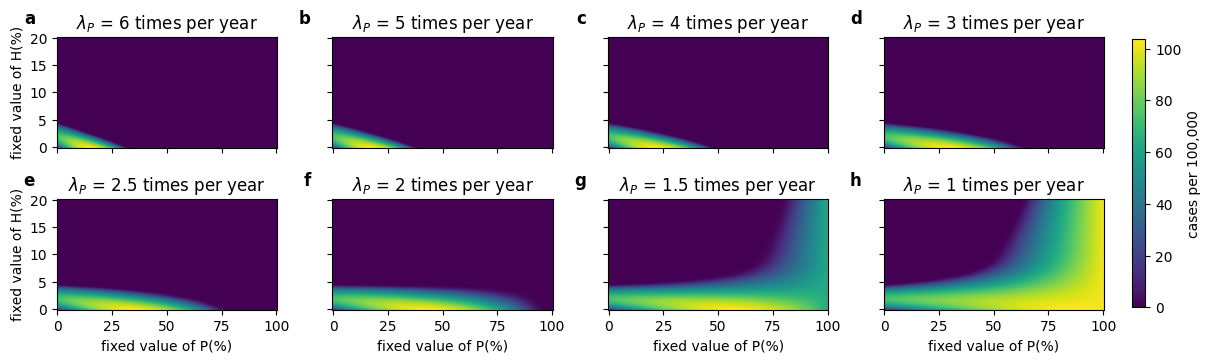

In [59]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")


# fig.suptitle("Detected new infections (i.e., transition from Ia to T + Is to T)")


plt.show()

# Save the results to a file
fig.savefig("../figures/detected_infections.pdf", format="pdf")

## Detected new asymptomatic infections (i.e., transition from Ia to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\2811053935.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


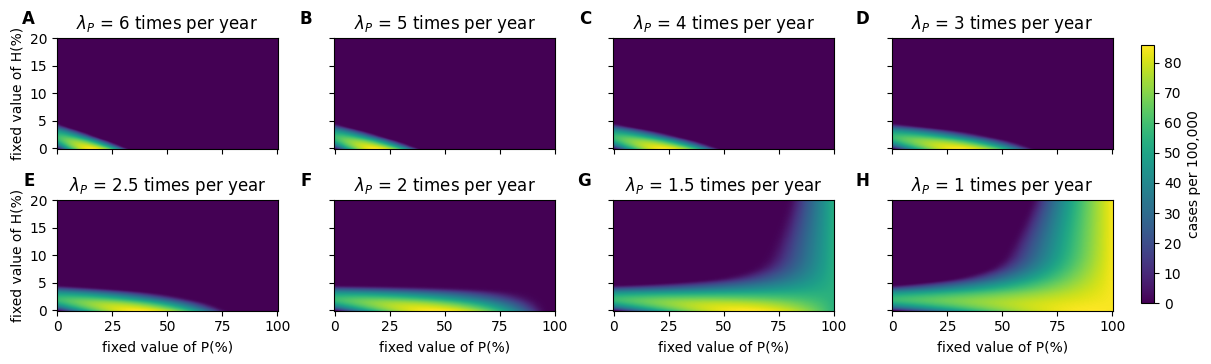

In [11]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_asymp_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_asymp_tests"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle("Detected new asymptomatic infections (i.e., transition from Ia to T)")

plt.show()

## Detected new symptomatic infections (i.e., transition from Is to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\4245869628.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


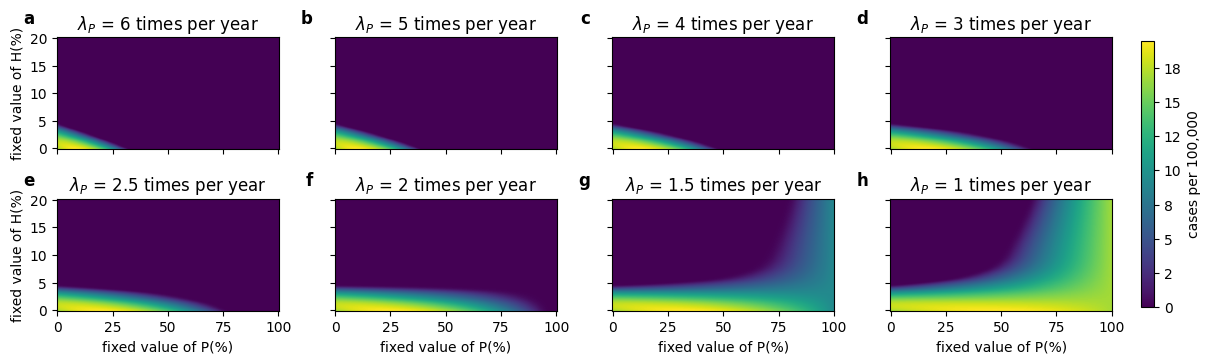

In [28]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_symp_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_symp_tests = results[lambda_P]["res_symp_tests"]
    cax = ax.imshow(res_symp_tests, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle(
#     "Detected new symptomatic infections (i.e., transition from Is to T)"
# )


plt.show()

## Lambda STI

<>:59: SyntaxWarning: invalid escape sequence '\l'
<>:59: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\4021453845.py:59: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


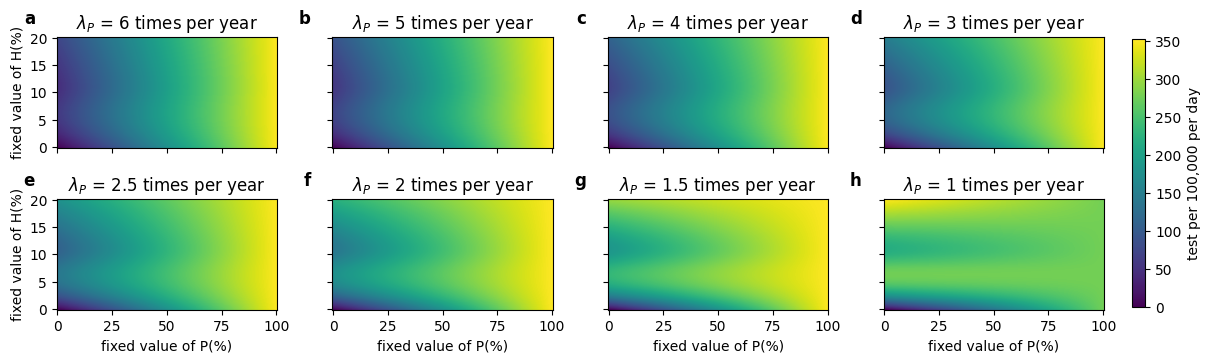

In [29]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    total_lambda = lambda_P + lambda_H + args["lambda_0_a"]
    cax = ax.imshow(total_lambda, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("test per 100,000 per day")

# fig.suptitle(
#     "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
#     fontweight="bold",
# )

plt.show()

## Lambda H

<>:61: SyntaxWarning: invalid escape sequence '\l'
<>:61: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\3532734073.py:61: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


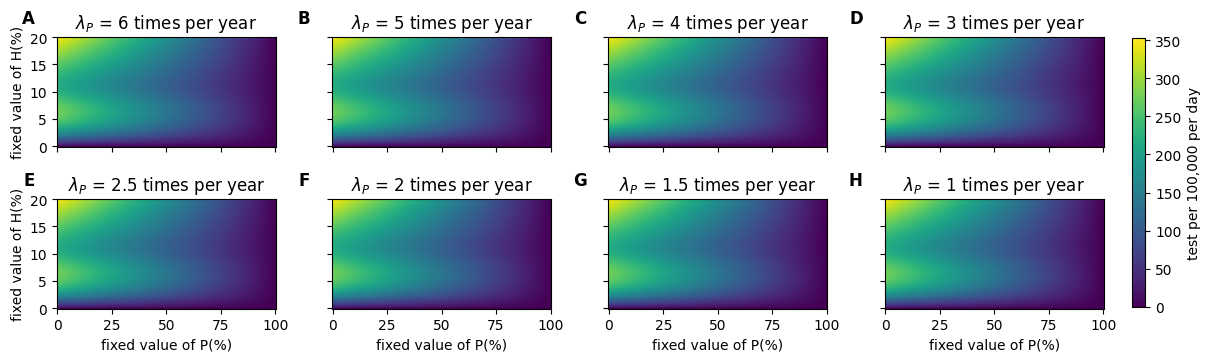

In [22]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

# Store m values for each H
m_values = np.zeros(len(Hs))

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            m_values[i] = m
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)

    ax = axes.flat[idx]
    cax = ax.imshow(lambda_H, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("test per 100,000 per day")

# fig.suptitle(
#     "$\lambda_H \cdot (1-P) $",
#     fontweight="bold",
# )

plt.show()

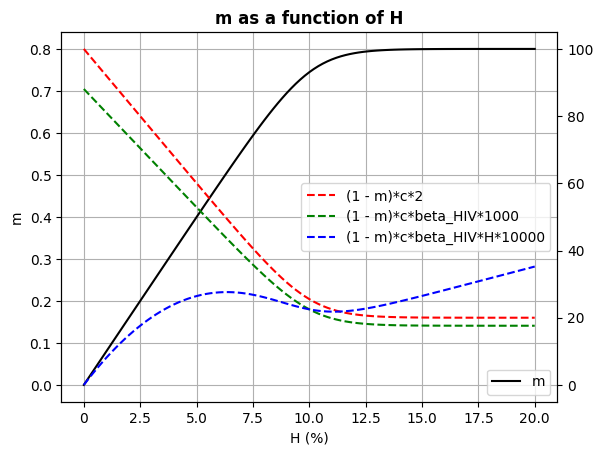

In [103]:
# Plot m values as a function of H
fig, ax = plt.subplots(1, 1)
dummy_P = np.linspace(0, 1, 101)
axR = ax.twinx()
ax.plot(Hs, m_values, color="black", label="m")
axR.plot(
    Hs,
    ((1 - m_values) * args["c"] * 2),
    color="red",
    linestyle="--",
    label="(1 - m)*c*2",
)
axR.plot(
    Hs,
    (args["c"] * (1 - m_values) * args["beta_HIV"] * 1000),
    color="green",
    linestyle="--",
    label="(1 - m)*c*beta_HIV*1000",
)
axR.plot(
    Hs,
    (args["c"] * (1 - m_values) * args["beta_HIV"] * Hs * 10000),
    color="blue",
    linestyle="--",
    label="(1 - m)*c*beta_HIV*H*10000",
)
ax.set_xlabel("H (%)")
ax.set_ylabel("m")
ax.set_title("m as a function of H", fontweight="bold")
ax.set_xticks([0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200])
ax.set_xticklabels(
    [
        "0",
        "2.5",
        "5.0",
        "7.5",
        "10.0",
        "12.5",
        "15.0",
        "17.5",
        "20.0",
    ]
)
ax.grid(True)
ax.legend(loc="lower right")
axR.legend(loc="center right")

## Lambda P

<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_32016\2345953081.py:56: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


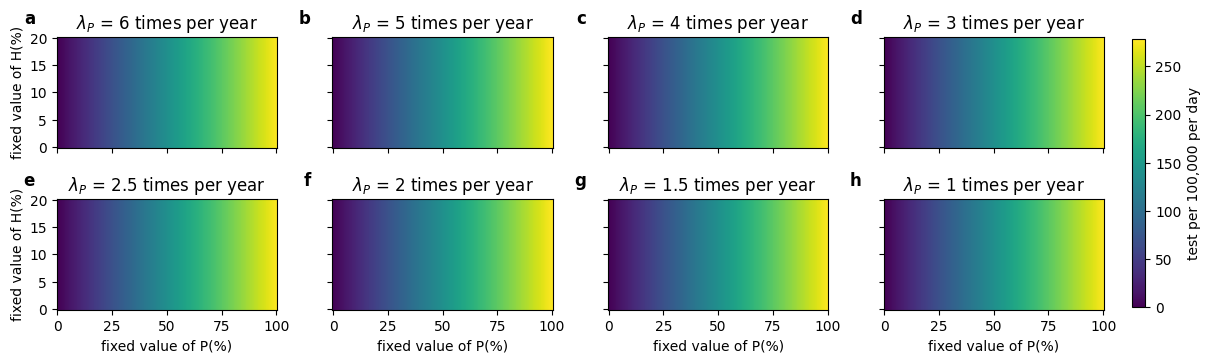

In [30]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    cax = ax.imshow(lambda_P, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("test per 100,000 per day")
# fig.suptitle(
#     "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
#     fontweight="bold",
# )

plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_42928\3164157755.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


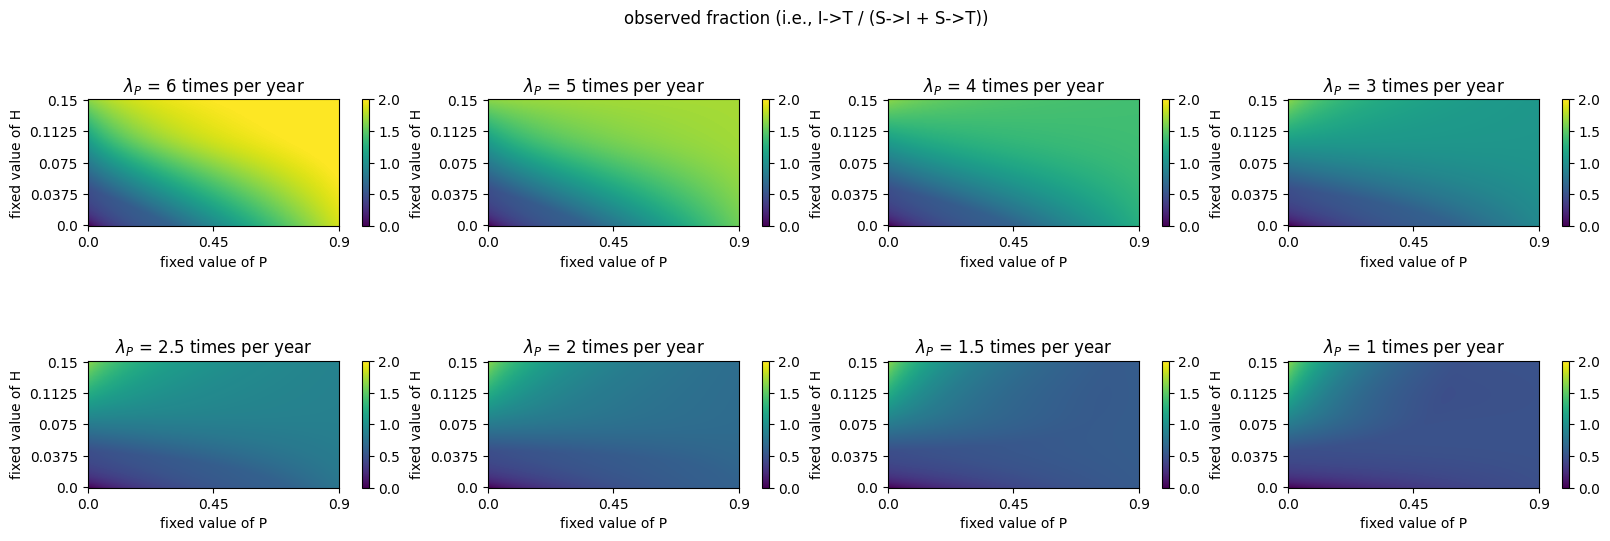

In [7]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    res_tests = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_tests / res_infections, origin="lower", vmin=0, vmax=2)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction (i.e., I->T / (S->I + S->T))")

plt.show()

In [ ]:
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]
num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 4.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_I = results[lambda_P]["res_I"]
    res_T = results[lambda_P]["res_T"]
    cax = ax.imshow(res_I - res_T, origin="lower", vmin=0, vmax=0.7)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction T/(T+I)")

plt.show()